## Load data

In [5]:
import pandas as pd
import ast
import numpy as np

# Load in data
admissions = 'tedsa_puf_2019.csv'
df_raw = pd.read_csv(f'../../Downloads/{admissions}')

## Filter out select rows and columns

In [6]:
# Get count of original number of rows
old_rows = len(df_raw)

# Drop defined columns (year of admission, case id, geographic metro area, geographic division, geographic region)
# columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010', 'DIVISION', 'REGION']
columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010']
df = df_raw.drop(columns=columns_to_drop)
print(f'Dropped {len(columns_to_drop)} columns ({len(df.columns)} remain)')

# Drop values where dependent variable is unknown
df = df[df['METHUSE'] != -9]

# Only keep patients admitted with self-described use of an opioid as their primary substance use (i.e., SUB1 = 5, 6, or 7)
df = df[df['SUB1'].between(5, 7)]
new_rows = len(df)
percent_change = round(100*(old_rows-new_rows)/old_rows, 1)
print(f'Dropped {"{:,}".format(old_rows-new_rows)} observations or {percent_change}% of the data ({"{:,}".format(new_rows)} rows remain)')

df = df.reset_index(drop='index')

Dropped 3 columns (59 remain)
Dropped 1,340,233 observations or 71.9% of the data (524,134 rows remain)


## Balance dataset

In [7]:
# Split into two dataframes, printing result
df_ones = df[df['METHUSE']==1]
df_twos = df[df['METHUSE']==2]
print('Classes before down-sampling:', len(df_ones), len(df_twos))

# Sample down df_twos to the length of df_ones, printing result
ratio = len(df_ones)/len(df_twos)
df_twos = df_twos.sample(frac=ratio)
print('Classes after down-sampling:', len(df_ones), len(df_twos))

# Recombine and shuffle for good measure
df = pd.concat([df_ones, df_twos], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

Classes before down-sampling: 211743 312391
Classes after down-sampling: 211743 211743


## Make dataset human-readable

In [8]:
# Load in variable dictionary
with open('VariableDictionary.txt') as file:
    variable_dict_string = file.read()
    variable_dict = ast.literal_eval(variable_dict_string)

# Rename entries in column according to dictionary
df2 = df.copy()
for col, col_dict in variable_dict.items():
    if col in df2.columns:
        for old_value, new_value in variable_dict[col].items():
            df2[col] = df2[col].replace(old_value, new_value)

# Rename "-9" values as "Unknown"
for col in df2.columns:
    df2[col] = df2[col].replace(-9, 'Unknown')

# Merge DETNLF (detailed not in labor force) into EMPLOY==4 (not in labor force)
detailed_employ = []

for idx, value in df2.iterrows():
    if value['EMPLOY'] == 'NotInLaborForce':
        if value['DETNLF'] == 'Unknown':
            # Assign 'UnknownNotInLaborForce' if 'NotInLaborForce' and 'Unknown'
            detailed_employ.append('UnknownNotInLaborForce')
        else:
            # Otherwise, assign as the DETNLF value
            detailed_employ.append(value['DETNLF'])
    else:
        # Assign the EMPLOY value if not 'NotInLaborForce'
        detailed_employ.append(value['EMPLOY'])

# Add a new column for detailed employment and drop the two source columns
df2['DETEMPLOY'] = detailed_employ
df2 = df2.drop(columns=['EMPLOY', 'DETNLF'])

# Convert dependent variable to binary integer
df2['METHUSE'] = df2['METHUSE'].replace('MethUse', 1)
df2['METHUSE'] = df2['METHUSE'].replace('NoMethUse', 0)

# XGBoost and Shapley

### Make machine-readable dataset (encoding)

In [9]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df4 = df2.copy()
# df4 = df4.sample(frac=0.1)  # small size for testing code

df4['STFIPS'] = df4['STFIPS'].astype('category').cat.codes
df4['EDUC'] = OrdinalEncoder(categories=[['Unknown', 'Grade8OrLess', 'Grade9To11', 'Grade12OrGED', '1To3yCollege', '4yCollegePlus']]).fit_transform(df4[['EDUC']])
df4['MARSTAT'] = df4['MARSTAT'].astype('category').cat.codes
df4['SERVICES'] = df4['SERVICES'].astype('category').cat.codes
df4['DETCRIM'] = df4['DETCRIM'].astype('category').cat.codes
df4['NOPRIOR'] = OrdinalEncoder(categories=[['Unknown', '0PriorTreatments', '1PriorTreatments', '2PriorTreatments', '3PriorTreatments',
                                            '4PriorTreatments', '5PlusPriorTreatments']]).fit_transform(df4[['NOPRIOR']])
df4['PSOURCE'] = df4['PSOURCE'].astype('category').cat.codes
df4['ARRESTS'] = OrdinalEncoder(categories=[['Unknown', '0Arrest', '1Arrest', '2PlusArrest']]).fit_transform(df4[['ARRESTS']])
# df4['METHUSE'] = df4['METHUSE'].astype('category').cat.codes
df4['PSYPROB'] = df4['PSYPROB'].astype('category').cat.codes
df4['PREG'] = df4['PREG'].astype('category').cat.codes
df4['GENDER'] = df4['GENDER'].astype('category').cat.codes
df4['VET'] = df4['VET'].astype('category').cat.codes
df4['LIVARAG'] = df4['LIVARAG'].astype('category').cat.codes
df4['DAYWAIT'] = OrdinalEncoder(categories=[['Unknown', '0DaysWait', '1To7DaysWait', '8To14DaysWait', '15To30DaysWait',
                                            '31PlusDaysWait']]).fit_transform(df4[['DAYWAIT']])
df4['DSMCRIT'] = df4['DSMCRIT'].astype('category').cat.codes
df4['AGE'] = OrdinalEncoder(categories=[['Age12To14', 'Age15To17', 'Age18To20', 'Age21To24', 'Age25To29', 'Age30To34', 'Age35To39', 'Age40To44',
                                        'Age45To49', 'Age50To54', 'Age55To64', 'Age65Plus' ]]).fit_transform(df4[['AGE']])
df4['RACE'] = df4['RACE'].astype('category').cat.codes
df4['ETHNIC'] = df4['ETHNIC'].astype('category').cat.codes
df4['PRIMINC'] = df4['PRIMINC'].astype('category').cat.codes
df4['SUB1'] = df4['SUB1'].astype('category').cat.codes
df4['SUB2'] = df4['SUB2'].astype('category').cat.codes
df4['SUB3'] = df4['SUB3'].astype('category').cat.codes
df4['ROUTE1'] = df4['ROUTE1'].astype('category').cat.codes
df4['ROUTE2'] = df4['ROUTE2'].astype('category').cat.codes
df4['ROUTE3'] = df4['ROUTE3'].astype('category').cat.codes
df4['FREQ1'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ1']])
df4['FREQ2'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ2']])
df4['FREQ3'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ3']])
df4['FRSTUSE1'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE1']])
df4['FRSTUSE2'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE2']])
df4['FRSTUSE3'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE3']])
df4['HLTHINS'] = df4['HLTHINS'].astype('category').cat.codes
df4['PRIMPAY'] = df4['PRIMPAY'].astype('category').cat.codes
df4['FREQ_ATND_SELF_HELP'] = OrdinalEncoder(categories=[['Unknown', 'NoAttendance', 'SomeAttendance', '1To3TimesPastMonth', '4To7TimesPastMonth',
                                                        '8To30TimesPastMonth']]).fit_transform(df4[['FREQ_ATND_SELF_HELP']])
df4['ALCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['ALCFLG']])
df4['COKEFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['COKEFLG']])
df4['MARFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MARFLG']])
df4['HERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HERFLG']])
df4['METHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['METHFLG']])
df4['OPSYNFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OPSYNFLG']])
df4['PCPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['PCPFLG']])
df4['HALLFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HALLFLG']])
df4['MTHAMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MTHAMFLG']])
df4['AMPHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['AMPHFLG']])
df4['STIMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['STIMFLG']])
df4['BENZFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BENZFLG']])
df4['TRNQFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['TRNQFLG']])
df4['BARBFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BARBFLG']])
df4['SEDHPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['SEDHPFLG']])
df4['INHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['INHFLG']])
df4['OTCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTCFLG']])
df4['OTHERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTHERFLG']])
df4['DIVISION'] = df4['DIVISION'].astype('category').cat.codes
df4['REGION'] = df4['REGION'].astype('category').cat.codes
df4['IDU'] = OrdinalEncoder(categories=[['NoIDU', 'IDU']]).fit_transform(df4[['IDU']])
df4['ALCDRUG'] = OrdinalEncoder(categories=[['OtherDrugs', 'AlcoholAndDrugs']]).fit_transform(df4[['ALCDRUG']])
df4['DETEMPLOY'] = df4['DETEMPLOY'].astype('category').cat.codes

## Train XG Boost model

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df4.drop('METHUSE', axis=1)
y = df4['METHUSE'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Search the parameter grid
# Docs: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-
defined_space={'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
       'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
       'max_depth': hp.quniform("max_depth", 3, 27, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', range(100, 1000)),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
    }

def objective(space):
    clf = xgb.XGBClassifier(colsample_bytree=round(space['colsample_bytree'], 0),
                          early_stopping_rounds=10,
                          eta=space['eta'],
                          eval_metric='auc',
                          gamma=space['gamma'],
                          learning_rate=space['learning_rate'],
                          max_depth=int(round(space['max_depth'], 0)),
                          min_child_weight=space['min_child_weight'],
                          n_estimators=space['n_estimators'],
                          objective='binary:logistic',
                          reg_alpha=space['reg_alpha'],
                          reg_lambda=space['reg_lambda'],
                          seed=24,
                          subsample=round(space['subsample'], 0))

    # Evaluate the model and record performance metrics
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test,y_pred)

    print (f"Accuracy: {round(accuracy, 4)}, AUC: {round(auc, 4)}")
    return {'loss': -accuracy, 'status': STATUS_OK }

In [23]:
# Begin training
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = defined_space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

Accuracy: 0.8437, AUC: 0.9286                           
Accuracy: 0.8441, AUC: 0.9284                                                        
Accuracy: 0.8394, AUC: 0.925                                                         
Accuracy: 0.7601, AUC: 0.8334                                                        
Accuracy: 0.6563, AUC: 0.7149                                                        
Accuracy: 0.8496, AUC: 0.9336                                                        
Accuracy: 0.6164, AUC: 0.6656                                                        
Accuracy: 0.6652, AUC: 0.7231                                                        
Accuracy: 0.8395, AUC: 0.9247                                                        
Accuracy: 0.8447, AUC: 0.9294                                                        
Accuracy: 0.8394, AUC: 0.9255                                                         
Accuracy: 0.8367, AUC: 0.9232                                                     

In [62]:
"""
# Best from 100 runs (without REGION, DIVISION)

 {'colsample_bytree': 0.61,
 'eta': 0.25,
 'gamma': 0.8,
 'learning_rate': 0.22,
 'max_depth': 16.0,
 'min_child_weight': 0.0,
 'n_estimators': 812,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9241629285526229,
 'subsample': 0.9}
"""

# best_hyperparams = {'colsample_bytree': 0.61,
#                      'eta': 0.25,
#                      'gamma': 0.8,
#                      'learning_rate': 0.22,
#                      'max_depth': 16.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 812,
#                      'reg_alpha': 40.0,
#                      'reg_lambda': 0.9241629285526229,
#                      'subsample': 0.9}

# Best from 100 runs (85% accuracy, 0.933 AUC)
""""
 {'colsample_bytree': 0.5700000000000001,
 'eta': 0.25,
 'gamma': 0.6000000000000001,
 'learning_rate': 0.26,
 'max_depth': 19.0,
 'min_child_weight': 0.0,
 'n_estimators': 525,
 'reg_alpha': 47.0,
 'reg_lambda': 0.4282630657696102,
 'subsample': 0.75}
"""

# best_hyperparams = {'colsample_bytree': 0.57,
#                      'eta': 0.25,
#                      'gamma': 0.6,
#                      'learning_rate': 0.26,
#                      'max_depth': 19.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 525,
#                      'reg_alpha': 47.0,
#                      'reg_lambda': 0.4282630657696102,
#                      'subsample': 0.75}

# Best from 1000 runs
""""
{'colsample_bytree': 0.62,
 'eta': 0.30000000000000004,
 'gamma': 0.5,
 'learning_rate': 0.18,
 'max_depth': 27.0,
 'min_child_weight': 0.0,
 'n_estimators': 637,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9778997768026216,
 'subsample': 0.8500000000000001}
"""

# best_hyperparams = {'colsample_bytree': 0.62,
#                      'eta': 0.30,
#                      'gamma': 0.5,
#                      'learning_rate': 0.18,
#                      'max_depth': 27.0,
#                      'min_child_weight': 0.0,
#                      'n_estimators': 637,
#                      'reg_alpha': 40.0,
#                      'reg_lambda': 0.9778997768026216,
#                      'subsample': 0.85}

best_hyperparams

{'colsample_bytree': 0.62,
 'eta': 0.30000000000000004,
 'gamma': 0.5,
 'learning_rate': 0.18,
 'max_depth': 27.0,
 'min_child_weight': 0.0,
 'n_estimators': 637,
 'reg_alpha': 40.0,
 'reg_lambda': 0.9778997768026216,
 'subsample': 0.8500000000000001}

In [25]:
# Train best model
best_hyperparams_formatted = best_hyperparams.copy()
best_hyperparams_formatted['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams_formatted['eval_metric'] = 'auc'
best_hyperparams_formatted['objective'] = 'binary:logistic'
best_hyperparams_formatted['seed'] = 24

best_model = xgb.XGBClassifier(**best_hyperparams_formatted)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.62, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.30000000000000004,
              eval_metric='auc', feature_types=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=27, max_leaves=None,
              min_child_weight=0.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=637, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
# Evaluate the model and record performance metrics
evaluation = [( X_train, y_train), ( X_test, y_test)]
best_pred = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_pred>0.5)
y_best_pred = best_model.predict_proba(X_test)[:,1]
best_auc = roc_auc_score(y_test,y_best_pred)

print (f"Accuracy: {round(best_accuracy, 4)}, AUC: {round(best_auc, 4)}")

Accuracy: 0.8518, AUC: 0.9351


### Interpretability

In [27]:
import shap
import numpy as np

# Generate Shapley values
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[11:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [63]:
shap_values   # Can we export these values as a csv? Trying to find a way to not have to run them each time

.values =
array([[-2.72757895e-02,  3.42021286e-02,  3.73061784e-02, ...,
         2.80914884e-02,  6.93892129e-03,  2.36243457e-02],
       [-4.01583374e-01, -2.32076552e-02,  3.59664368e-03, ...,
         1.31237805e-02, -5.81168337e-04, -1.92546368e-01],
       [-1.32091586e-02, -8.79201367e-02, -6.49405479e-01, ...,
        -3.67406234e-02,  1.60335726e-03, -6.76377863e-02],
       ...,
       [ 4.61404532e-01, -4.84171025e-02,  7.41933333e-03, ...,
         4.33878638e-02,  5.57194650e-03, -1.07471779e-01],
       [ 5.78675233e-02, -2.56198272e-02, -3.41308080e-02, ...,
        -8.98936577e-03,  6.55724620e-03,  1.59859117e-02],
       [-3.40169877e-01,  3.70564274e-02, -4.66050906e-03, ...,
        -4.11690511e-02,  2.54947064e-03, -3.58299278e-02]], dtype=float32)

.base_values =
array([-0.01371378, -0.01371378, -0.01371378, ..., -0.01371378,
       -0.01371378, -0.01371378], dtype=float32)

.data =
array([[ 4.,  3.,  4., ...,  1.,  0.,  4.],
       [18.,  3.,  1., ...,  1.,  0.

In [29]:
import os
os.system('say "Work complete"')

0

In [64]:
def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

# Show table of top Shapley values
feature_names = X.columns
result = pd.DataFrame(shap_values.values, columns=feature_names, index=X.index)
# result.to_csv('shapley_results.csv', index=False)

values = np.abs(result.values).mean(0)
abs_values = absolute_share(np.abs(result.values).mean(0))
shap_importance = pd.DataFrame(list(zip(feature_names, values, abs_values)), columns=['feature_name','feature_importance', 'feature_importance_out_of_100'])
shap_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_importance.reset_index(drop=True)

,feature_name,feature_importance,feature_importance_out_of_100
0,SERVICES,1.246796,0.244564
1,STFIPS,0.527862,0.103542
2,REGION,0.326182,0.063982
3,DIVISION,0.323002,0.063358
4,PSOURCE,0.320034,0.062776
5,NOPRIOR,0.204219,0.040058
6,FREQ1,0.162377,0.031851
7,DSMCRIT,0.115971,0.022748
8,FREQ_ATND_SELF_HELP,0.105577,0.020709
9,PSYPROB,0.103412,0.020285


In [65]:
result

,STFIPS,EDUC,MARSTAT,SERVICES,DETCRIM,NOPRIOR,PSOURCE,ARRESTS,PSYPROB,PREG,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG,DETEMPLOY
0,-0.027276,0.034202,0.037306,1.759057,0.057306,-0.185651,0.612726,0.026401,0.044964,-0.029476,...,0.000044,0.001316,-0.000008,0.000103,0.000911,0.198315,-0.081383,0.028091,0.006939,0.023624
1,-0.401583,-0.023208,0.003597,0.493036,-0.038772,0.183624,-0.855585,-0.010859,-0.149777,-0.039058,...,-0.000001,0.000420,-0.000003,0.000052,-0.001108,0.049429,0.211318,0.013124,-0.000581,-0.192546
2,-0.013209,-0.087920,-0.649405,-1.881875,-0.006209,-1.751182,0.047649,-1.333821,-0.306884,-0.045212,...,0.000012,0.000272,0.000021,0.000036,0.000744,0.152117,0.055760,-0.036741,0.001603,-0.067638
3,-0.178470,0.007563,0.021294,-0.677321,0.010459,0.187412,0.256289,0.017983,0.122366,0.016073,...,-0.000002,0.000402,-0.000002,0.000085,0.001812,0.116717,0.292811,-0.001461,0.001202,-0.049742
4,-0.459202,-0.022918,0.025873,-1.471329,0.011100,0.150777,0.027707,0.023484,-0.230878,-0.018827,...,0.000011,0.000463,0.000002,0.000076,0.001163,-0.078141,0.198282,-0.035844,0.001959,0.002945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423481,-0.241539,0.014011,0.056404,1.881586,0.041737,0.040791,0.344572,0.033008,0.047923,-0.082826,...,0.000037,0.000789,0.000005,0.000520,-0.000658,0.167590,0.107744,-0.052536,0.001422,0.039340
423482,-1.261888,-0.049323,-0.020080,-2.240649,0.005329,0.016425,0.116855,0.012796,-0.095944,0.110239,...,0.000012,0.000451,-0.000056,0.000048,0.002330,-0.793493,-0.538630,-0.028178,0.002284,-0.093956
423483,0.461405,-0.048417,0.007419,1.930577,0.016789,-0.005944,0.474968,-0.415868,0.069330,-0.012404,...,0.000005,0.000808,0.000007,0.000051,0.001751,-0.149339,-0.209750,0.043388,0.005572,-0.107472
423484,0.057868,-0.025620,-0.034131,1.852781,0.040782,-0.250118,0.557429,0.021042,-0.031086,0.058657,...,0.000054,0.000990,-0.000002,0.000076,-0.000002,0.149843,-0.124077,-0.008989,0.006557,0.015986


In [147]:
livarag_dict = {0:'DependLiving', 1:'Homeless', 2:'IndependentLiving', 3:'Unknown'}
print(livarag_dict)
X.value_counts('LIVARAG')
# df2.value_counts('LIVARAG')

{0: 'DependLiving', 1: 'Homeless', 2: 'IndependentLiving', 3: 'Unknown'}


LIVARAG
2    268885
1     66100
0     65813
3     22688
dtype: int64

In [31]:
# result = pd.read_csv('shapley_results.csv')
result_homeless = result.copy()
result_homeless.insert(0, 'homeless', X['LIVARAG'])
result_homeless.insert(1, 'absolute_livarag', abs(result_homeless['LIVARAG']))
result_homeless_grouped = result_homeless.groupby('homeless').mean()[['LIVARAG', 'absolute_livarag']]
result_homeless_var = result_homeless_grouped.iloc[1]['LIVARAG']
result_homeless_grouped

,LIVARAG,absolute_livarag
homeless,,
0,-0.120074,0.123803
1,-0.057808,0.065919
2,0.062850,0.062943
3,-0.108292,0.117648


In [32]:
# Group by state for three known groups
# Split into three dataframes
df2_homeless = df2[df2['LIVARAG']=='Homeless'][['STFIPS']]
df2_independent = df2[df2['LIVARAG']=='IndependentLiving'][['STFIPS']]
df2_dependent = df2[df2['LIVARAG']=='DependLiving'][['STFIPS']]

# Merge with Shapley values
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'livarag_shapley'})
result_state_homeless = pd.merge(result_shapley, df2_homeless, how='inner', left_index=True, right_index=True)
result_state_independent = pd.merge(result_shapley, df2_independent, how='inner', left_index=True, right_index=True)
result_state_dependent = pd.merge(result_shapley, df2_dependent, how='inner', left_index=True, right_index=True)
result_state_housed = pd.concat([result_state_independent, result_state_dependent], axis=0)

# Group to state-level averages and merge
result_state_homeless_mean = result_state_homeless.groupby('STFIPS').mean().rename(columns={'livarag_shapley':'homeless_shapley'})
result_state_housed_mean = result_state_housed.groupby('STFIPS').mean().rename(columns={'livarag_shapley':'housed_shapley'})
result_state_mean = result_state_homeless_mean.copy()
result_state_mean['housed_shapley'] = result_state_housed_mean['housed_shapley']

# Add national averages
homeless_avg = result_state_homeless['livarag_shapley'].mean()
housed_avg = result_state_housed['livarag_shapley'].mean()
national_avg = pd.DataFrame(data={'homeless_shapley':[homeless_avg], 'housed_shapley':housed_avg}, index=['USA'])
result_state_mean = pd.concat([result_state_mean, national_avg], axis=0)

# Calculate difference and ttest
result_state_mean['difference_shapley'] = result_state_mean['homeless_shapley']-result_state_mean['housed_shapley']

# Save, print results
# result_state_mean.to_csv('shap_importance_by_state.csv')
result_state_mean

In [66]:
result_state_housed

,livarag_shapley,STFIPS
2,0.034146,NY
3,0.043913,MA
4,0.047037,MA
5,0.043162,AL
6,0.076147,MD
...,...,...
423463,-0.363619,MI
423469,-0.114153,CT
423470,-0.197718,NM
423473,-0.292675,OH


### Add t-test

In [34]:
import numpy as np
from scipy.stats import ttest_ind

# Merge with Shapley values
df2_1 = df2[df2['LIVARAG'] != 'Unknown']
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'livarag_shapley'})
result_state = pd.merge(result_shapley, df2_1[['STFIPS', 'LIVARAG']], how='inner', left_index=True, right_index=True)
result_state['LIVARAG'] = result_state['LIVARAG'].replace(['IndependentLiving', 'DependLiving'], 'Housed')

# Duplicate results listing them as national
result_national = result_state.copy()
result_national['STFIPS'] = 'USA'
result_state_national = pd.concat([result_state, result_national])
result_state_national = result_state_national.reset_index(drop=True)

# Create assets for loop
state_array = result_state_national['STFIPS'].sort_values().unique()
state_list = state_array.tolist()
state_list.append('USA')
df_state = pd.DataFrame(columns=['Homeless', 'Housed', 'Difference', 'TStat', 'PValue', 'Significance'])

# Loop through each state
for s in state_list:
    dftemp = result_state_national[result_state_national['STFIPS'] == s]

    # Group by living arrangement and MOUD, then store those variables for later (if they exist)
    dft_grouped = dftemp.groupby('LIVARAG')['livarag_shapley'].mean()

    try:
        homeless_moud = dft_grouped.loc['Homeless']
    except KeyError:
        print(f"Insufficient homeless admissions to form a group in {s}")
        homeless_moud = np.nan

    try:
        housed_moud = dft_grouped.loc['Housed']
    except KeyError:
        print(f"Insufficient housed admissions to form a group in {s}")
        housed_moud = np.nan

    # Perform a t-test between the two groups
    group_A_values = dftemp[dftemp['LIVARAG'] == 'Homeless']['livarag_shapley']
    group_B_values = dftemp[dftemp['LIVARAG'] == 'Housed']['livarag_shapley']
    t_stat, p_value = ttest_ind(group_A_values, group_B_values)

    # Add significance based on p-value
    if p_value < 0.001:
        significance = '****'
    elif p_value < 0.01:
        significance = '***'
    elif p_value < 0.05:
        significance = '**'
    elif p_value <0.1:
        significance = '*'
    else:
        significance = ''

    # Add values to a dictionary and round
    dict_results = {'Homeless':homeless_moud, 'Housed':housed_moud, 'Difference':homeless_moud-housed_moud, 'TStat':t_stat, 'PValue':p_value}
    for key, value in dict_results.items():
        dict_results[key] = round(value, 6)

    # Add significance and to dictionary and then dictionary to dataframe
    dict_results['Significance'] = significance
    df_state.loc[s] = dict_results

# df_state.to_csv('shapley_with_ttest.csv') #uncomment to save file
df_state

,Homeless,Housed,Difference,TStat,PValue,Significance
AK,-0.019170,0.030995,-0.050165,-15.556488,0.000000,****
AL,-0.033164,-0.001429,-0.031735,-8.080899,0.000000,****
AR,-0.066827,0.014993,-0.081819,-13.678728,0.000000,****
CA,-0.117790,0.037434,-0.155224,-278.545366,0.000000,****
CO,-0.018993,0.031412,-0.050406,-23.666658,0.000000,****
CT,-0.051676,0.038167,-0.089843,-65.517994,0.000000,****
DC,-0.067285,-0.026174,-0.041111,-9.023708,0.000000,****
DE,-0.088398,0.042155,-0.130554,-54.590180,0.000000,****
GA,-0.074296,-0.011210,-0.063087,-9.733770,0.000000,****
HI,-0.057522,-0.010795,-0.046727,-5.707689,0.000000,****


# Plot Shapley values

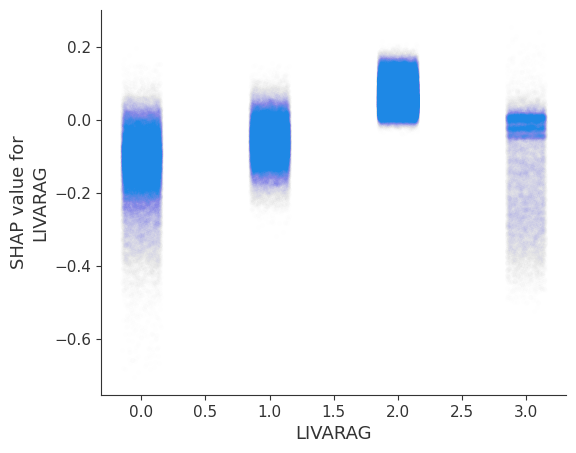

In [35]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

shap.dependence_plot('LIVARAG', shap_values.values, X, x_jitter=0.3, alpha=0.005, interaction_index=None)

In [36]:
shap_importance

,feature_name,feature_importance,feature_importance_out_of_100
3,SERVICES,1.246796,0.244564
0,STFIPS,0.527862,0.103542
53,REGION,0.326182,0.063982
52,DIVISION,0.323002,0.063358
6,PSOURCE,0.320034,0.062776
5,NOPRIOR,0.204219,0.040058
25,FREQ1,0.162377,0.031851
14,DSMCRIT,0.115971,0.022748
33,FREQ_ATND_SELF_HELP,0.105577,0.020709
8,PSYPROB,0.103412,0.020285


In [40]:
shap_importance
# shap_importance.to_csv('shap_importance.csv', index=False)

,feature_name,feature_importance,feature_importance_out_of_100
3,SERVICES,1.246796,0.244564
0,STFIPS,0.527862,0.103542
53,REGION,0.326182,0.063982
52,DIVISION,0.323002,0.063358
6,PSOURCE,0.320034,0.062776
5,NOPRIOR,0.204219,0.040058
25,FREQ1,0.162377,0.031851
14,DSMCRIT,0.115971,0.022748
33,FREQ_ATND_SELF_HELP,0.105577,0.020709
8,PSYPROB,0.103412,0.020285


,LIVARAG
0,-0.028547
1,-0.131106
2,0.034146
3,0.043913
4,0.047037
...,...
423481,0.104247
423482,0.076639
423483,0.080442
423484,0.062074


In [167]:
df3 = df2.copy()
df_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'shapley'})
df3 = pd.merge(df3[['LIVARAG']], df_shapley, left_index=True, right_index=True)

df3_dependent = df3[df3['LIVARAG']=='DependLiving'][['shapley']].rename(columns={'shapley':'Dependent Living'})
df3_homeless = df3[df3['LIVARAG']=='Homeless'][['shapley']].rename(columns={'shapley':'Homeless'})
df3_independent = df3[df3['LIVARAG']=='IndependentLiving'][['shapley']].rename(columns={'shapley':'Independent Living'})
df3_unknown = df3[df3['LIVARAG']=='Unknown'][['shapley']].rename(columns={'shapley':'Unknown'})

df3_1 = pd.merge(df3_dependent, df3_homeless, how='outer', left_index=True, right_index=True)
df3_2 = pd.merge(df3_1, df3_independent, how='outer', left_index=True, right_index=True)
df3_3 = pd.merge(df3_2, df3_unknown, how='outer', left_index=True, right_index=True)

df3_3

,Dependent Living,Homeless,Independent Living,Unknown
0,-0.028547,NaN,NaN,NaN
1,-0.131106,NaN,NaN,NaN
2,NaN,NaN,0.034146,NaN
3,NaN,NaN,0.043913,NaN
4,NaN,NaN,0.047037,NaN
...,...,...,...,...
423481,NaN,NaN,0.104247,NaN
423482,NaN,NaN,0.076639,NaN
423483,NaN,NaN,0.080442,NaN
423484,NaN,NaN,0.062074,NaN


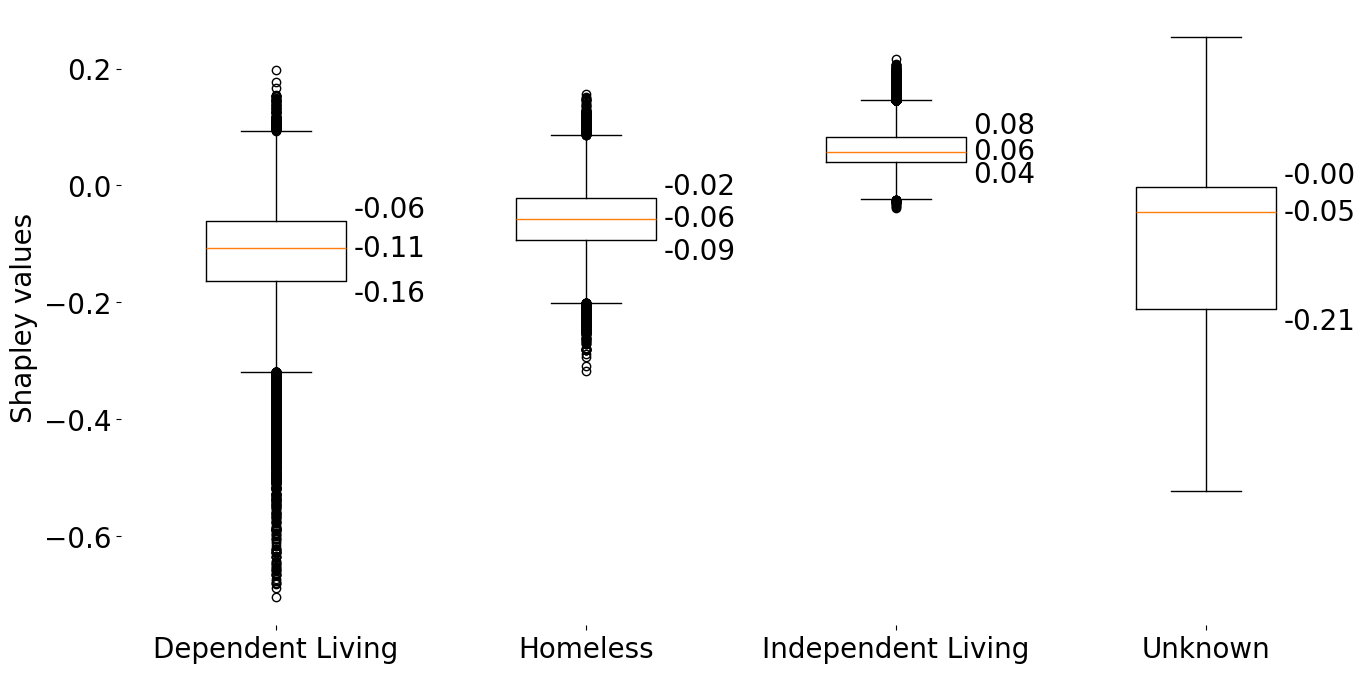

In [169]:
# Make a box plot of the Shapley values
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in df3_3.items()]))

# Create a box and whisker plot
fig, ax = plt.subplots(figsize=(16,8))
bp = ax.boxplot([df[col].dropna() for col in df.columns], labels=df.columns)

# Removing the border of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Adding median data labels
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]  # top of median line
    # Adjust x position to place labels to the right
    label_x_pos = x + 0.025  # Adjust this offset as needed
    ax.text(label_x_pos, y, f'{y:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=20)

    # Box top (Q3) and bottom (Q1)
    box_top = bp['boxes'][i].get_ydata()[2]
    box_bottom = bp['boxes'][i].get_ydata()[0]
    ax.text(i + 1.25, box_top + 0.02, f'{box_top:.2f}', verticalalignment='center', fontsize=20)
    ax.text(i + 1.25, box_bottom - 0.02, f'{box_bottom:.2f}', verticalalignment='center', fontsize=20)

# Adding titles and labels
plt.ylabel('Shapley values', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Save the plot as a PNG file
# plt.savefig('boxplot.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# Grouped feature importance

In [57]:
import pandas as pd
g = pd.read_csv('shap_importance_encoded.csv')  #update label and category, then regroup
# g['feature_importance'] = g['feature_importance'].str.rstrip('%').astype('float')/100 # if cast as percent string
# g['feature_importance_out_of_100'] = g['feature_importance_out_of_100'].str.rstrip('%').astype('float')/100
g

,feature_name,feature_label,feature_category,feature_importance,feature_importance_out_of_100
0,AGE,Age at admission,Demographic,0.0943,0.0185
1,ALCDRUG,Substance use type,Substance use history,0.0056,0.0011
2,ALCFLG,Alcohol reported at admission,Substance use history,0.0333,0.0065
3,AMPHFLG,Other amphetamines reported at admission,Substance use history,0.0020,0.0004
4,ARRESTS,Arrests in the past 30 days,Personal history,0.0889,0.0174
5,BARBFLG,Barbiturates reported at admission,Substance use history,0.0001,0.0000
6,BENZFLG,Benzodiazepines reported at admission,Substance use history,0.0053,0.0010
7,COKEFLG,Cocaine/crack reported at admission,Substance use history,0.0088,0.0017
8,DAYWAIT,Days waiting to enter substance use treatment,Coordination of care,0.0886,0.0174
9,DETCRIM,Detailed criminal justice referral,Coordination of care,0.0359,0.0070


In [59]:
g_grouped = g.groupby('feature_category').sum()['feature_importance_out_of_100'].sort_values(ascending=False)
# g_grouped.to_csv('shap_importance_grouped.csv')
g_grouped

feature_category
Coordination of care     0.3318
Geographic               0.2309
Substance use history    0.1649
Medical history          0.1132
Economic                 0.0864
Personal history         0.0400
Demographic              0.0327
Name: feature_importance_out_of_100, dtype: float64

In [60]:
g.sort_values(by='feature_importance_out_of_100', ascending=False)[['feature_label', 'feature_importance_out_of_100']].reset_index(drop=True)

,feature_label,feature_importance_out_of_100
0,Type of treatment service/setting,0.2446
1,Census state FIPS code,0.1035
2,Census region,0.0640
3,Census division,0.0634
4,Referral source,0.0628
5,Previous substance use treatment episodes,0.0401
6,Frequency of use (primary),0.0319
7,DSM diagnosis (SuDS 4 SuDS 19),0.0227
8,Attendance at substance use self-help groups i...,0.0207
9,Co-occurring mental and substance use disorders,0.0203
